--- Phase 1: Data Loading ---
数据加载成功: 15 条线路

--- Phase 2: Modeling ---
审计矩阵已导出至 '02_Audit_Matrix_New.xlsx'

--- Phase 3: Solving (Integer) ---

🚀 开始求解 (限时 60s)...
✅ 求解成功! Obj = 10,560.00

--- Phase 4: Bottleneck Analysis (Shadow Prices) ---

🧬 启动线性松弛分析 (Shadow Price Analysis)...
✅ 松弛求解成功，提取到 6 条关键边际信息。

🔍 === 关键资源瓶颈 (Top 5 Shadow Prices) ===
   Constraint  Shadow_Price  Slack
Dem_Shelter_E          22.0   -0.0
Dem_Shelter_B          14.0   -0.0
Dem_Shelter_C          12.0   -0.0
Dem_Shelter_A          10.0   -0.0
Dem_Shelter_D           8.0   -0.0

💡 洞察: 约束 'Dem_Shelter_E' 的影子价格为 22.00
   -> 这是一个配送成本最高的安置点。

--- Phase 5: Visualization ---


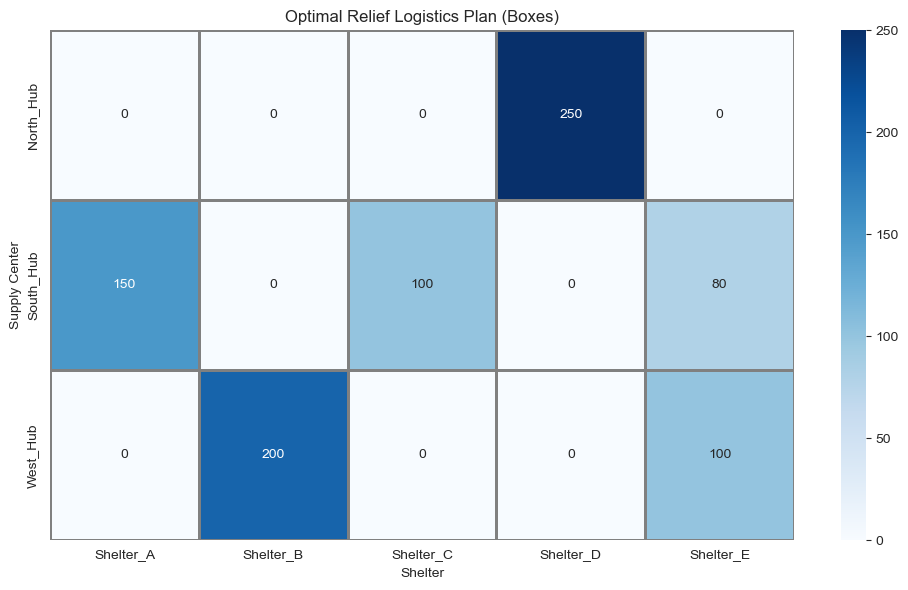

✅ 可视化图表已生成


In [1]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 0. 核心工具类 (Updated with Relaxed Solver)
# ==============================================================================
class PuLP_Solver_Capsule:
    def __init__(self, name="MCM_Optimization", sense='min'):
        """
        初始化优化器
        sense: 'max' 或 'min'
        """
        self.sense = pulp.LpMaximize if sense == 'max' else pulp.LpMinimize
        self.prob = pulp.LpProblem(name, self.sense)
        self.vars = {} 
        self.is_solved = False
        self.original_cats = {} # [NEW] 用于存储变量原始类型，确保回滚安全

    def add_variables(self, names, low_bound=0, up_bound=None, cat='Integer'):
        """添加变量并记录类型"""
        cat_map = {'Continuous': pulp.LpContinuous, 'Integer': pulp.LpInteger, 'Binary': pulp.LpBinary}
        pulp_cat = cat_map.get(cat, pulp.LpContinuous)
        
        # 创建变量
        # 注意：PuLP会自动加前缀，但我们存储时可以通过变量对象的name属性或者是这里的key来管理
        new_vars = pulp.LpVariable.dicts("Var", names, lowBound=low_bound, upBound=up_bound, cat=pulp_cat)
        self.vars.update(new_vars)
        
        # [NEW] 记录原始类型，以便后续松弛操作后恢复
        for k, v in new_vars.items():
            self.original_cats[v.name] = pulp_cat
        return new_vars

    def add_constraint(self, expr, sense, rhs, name):
        """添加约束"""
        if sense == '<=': c = (expr <= rhs)
        elif sense == '>=': c = (expr >= rhs)
        elif sense == '==': c = (expr == rhs)
        else: raise ValueError("Sense error")
        self.prob += c, name

    def set_objective(self, expr):
        """直接设置目标函数"""
        self.prob += expr

    def solve(self, time_limit=60):
        """[NEW] 求解 (增加防卡死限制)"""
        print(f"\n🚀 开始求解 (限时 {time_limit}s)...")
        solver = pulp.PULP_CBC_CMD(msg=0, timeLimit=time_limit)
        status = self.prob.solve(solver)
        self.is_solved = True
        
        status_str = pulp.LpStatus[status]
        if status != 1: # Not Optimal
            print(f"⚠️ 警告: 求解状态为 {status_str}")
            if status == -1: # Infeasible
                print(">>> 正在导出冲突模型 'Debug_Infeasible.lp'...")
                self.prob.writeLP("Debug_Infeasible.lp")
        else:
            print(f"✅ 求解成功! Obj = {pulp.value(self.prob.objective):,.2f}")
            
        return status_str

    def solve_relaxed(self):
        """
        【V2.0 核心黑科技】原子化线性松弛分析
        MIP -> LP -> Shadow Price -> MIP
        """
        print("\n🧬 启动线性松弛分析 (Shadow Price Analysis)...")
        
        # 1. 临时修改变量类型 (Integer -> Continuous)
        for v in self.prob.variables():
            v.cat = pulp.LpContinuous

        # 2. 求解 LP
        self.prob.solve(pulp.PULP_CBC_CMD(msg=0))
        
        # 3. 提取分析结果
        shadow_data = []
        if self.prob.status == 1:
            for name, c in self.prob.constraints.items():
                if abs(c.pi) > 1e-6: 
                    shadow_data.append({'Constraint': name, 'Shadow_Price': c.pi, 'Slack': c.slack})
            print(f"✅ 松弛求解成功，提取到 {len(shadow_data)} 条关键边际信息。")
        else:
            print("⚠️ 松弛模型无解，无法分析。")

        # 4. [关键] 恢复变量类型 (回滚现场)
        for v in self.prob.variables():
            if v.name in self.original_cats:
                 v.cat = self.original_cats[v.name]
        
        return pd.DataFrame(shadow_data).sort_values(by='Shadow_Price', key=abs, ascending=False)

    def export_audit_matrix(self):
        """导出审计矩阵"""
        data = []
        for name, c in self.prob.constraints.items():
            row = {'_Constraint': name, '_RHS': -c.constant}
            for var, coeff in c.items():
                row[var.name] = coeff
            data.append(row)
        return pd.DataFrame(data).fillna(0)
    
    def get_results_df(self):
        """获取结果"""
        if not self.is_solved: return None
        data = []
        for key, var in self.vars.items():
            data.append({'Variable': key, 'Value': var.varValue})
        return pd.DataFrame(data)

# ==============================================================================
# Main Execution Flow
# ==============================================================================

# --- Phase 1: 数据加载 (Data Loading) ---
print("--- Phase 1: Data Loading ---")
try:
    # 优先读取 Excel，如果报错则尝试 CSV
    try:
        df = pd.read_excel('00_Cleaned_Data.xlsx')
    except:
        df = pd.read_csv('00_Cleaned_Data.xlsx - Sheet1.csv') # 根据你提供的文件名备选
    print(f"数据加载成功: {len(df)} 条线路")
except Exception as e:
    print(f"❌ 数据文件读取失败: {e}")
    # 为了演示代码能跑通，这里构建一个简单的 Mock 数据 (如果在没有文件的情况下)
    # df = pd.DataFrame(...) 
    exit()

route_id_list = df['Route_ID'].tolist()
cost_map = df.set_index('Route_ID')['Cost_Per_Unit'].to_dict()

# --- Phase 2: 建模与审计 (Modeling & Auditing) ---
print("\n--- Phase 2: Modeling ---")
solver = PuLP_Solver_Capsule(name="Relief_Logistics_V2", sense='min')

# 1. 添加变量
solver.add_variables(names=route_id_list, cat='Integer', low_bound=0)

# 2. 添加约束
# Origin Capacity
for origin, group in df.groupby('Origin'):
    r_ids = group['Route_ID'].tolist()
    cap = group['Origin_Capacity'].iloc[0]
    # 使用 solver.vars[rid] 获取变量对象
    expr = pulp.lpSum([solver.vars[rid] for rid in r_ids])
    solver.add_constraint(expr, '<=', cap, f"Cap_{origin}")

# Destination Demand
for dest, group in df.groupby('Destination'):
    r_ids = group['Route_ID'].tolist()
    dem = group['Dest_Demand'].iloc[0]
    expr = pulp.lpSum([solver.vars[rid] for rid in r_ids])
    solver.add_constraint(expr, '>=', dem, f"Dem_{dest}")

# 3. 审计
audit_df = solver.export_audit_matrix()
audit_df.to_excel("02_Audit_Matrix_New.xlsx", index=False)
print("审计矩阵已导出至 '02_Audit_Matrix_New.xlsx'")

# --- Phase 3: 整数规划求解 (Integer Solving) ---
print("\n--- Phase 3: Solving (Integer) ---")
# 构建目标函数
obj_expr = pulp.lpSum([solver.vars[rid] * cost_map[rid] for rid in route_id_list])
solver.set_objective(obj_expr)

# 求解
status = solver.solve()

# --- Phase 4: 瓶颈分析 (Relaxed Analysis) [NEW] ---
print("\n--- Phase 4: Bottleneck Analysis (Shadow Prices) ---")
# 直接调用新方法，无需重新实例化
df_shadow = solver.solve_relaxed()

if not df_shadow.empty:
    print("\n🔍 === 关键资源瓶颈 (Top 5 Shadow Prices) ===")
    print(df_shadow.head(5).to_string(index=False))
    
    # 简单解读第一条
    top = df_shadow.iloc[0]
    print(f"\n💡 洞察: 约束 '{top['Constraint']}' 的影子价格为 {top['Shadow_Price']:.2f}")
    if "Cap_" in top['Constraint']:
        print("   -> 这是一个最紧缺的仓库，扩容能显著降低成本。")
    elif "Dem_" in top['Constraint']:
        print("   -> 这是一个配送成本最高的安置点。")
else:
    print("没有发现显著的非零影子价格。")

# --- Phase 5: 结果可视化 (Visualization) ---
print("\n--- Phase 5: Visualization ---")
if solver.is_solved and status == 'Optimal':
    # 获取结果
    res_df = solver.get_results_df()
    
    # 此时 Variable 列即为 Route_ID (因为用的是 vars 的 key)
    res_df.rename(columns={'Variable': 'Route_ID'}, inplace=True)
    
    # 合并原始信息
    df_viz = res_df.merge(df, on='Route_ID', how='left')
    
    # 数据透视
    matrix = df_viz.pivot_table(index='Origin', columns='Destination', values='Value', aggfunc='sum').fillna(0)
    
    # 绘图
    plt.figure(figsize=(10, 6))
    sns.set_style("white")
    sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues", linewidths=1, linecolor='gray')
    plt.title('Optimal Relief Logistics Plan (Boxes)')
    plt.ylabel('Supply Center')
    plt.xlabel('Shelter')
    plt.tight_layout()
    plt.show()
    print("✅ 可视化图表已生成")
else:
    print("⚠️ 无法生成图表：未找到最优解")